In [5]:
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model

from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras import preprocessing 

import glob
import os, os.path
from os.path import basename
import pandas as pd
import matplotlib.pyplot as plt
import PIL.Image

from PIL import Image

In [6]:
classification_list = ['apple','avocado', 'banana',  'kaki', 'lemon', 'orange', 'pumpkin']
classification_list

['apple', 'avocado', 'banana', 'kaki', 'lemon', 'orange', 'pumpkin']

In [7]:
BASE_DIR = '/home/aprameyo/Weekly_exercises/Week9/imageclassifier/imageclassifier/data/'


In [8]:
# define an image data generator
data_gen = preprocessing.image.ImageDataGenerator(
    # define the preprocessing function that should be applied to all images
    preprocessing_function=mobilenet_v2.preprocess_input,
    # fill_mode='nearest',
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # horizontal_flip=True, 
    # zoom_range=0.2,
    # shear_range=0.2    
)

In [9]:
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(
        directory=BASE_DIR,
        class_mode="categorical",
        classes=classification_list,
        batch_size=600,
        target_size=(224, 224)
)

Found 1116 images belonging to 7 classes.


In [10]:
# load in all images at once
xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

((600, 224, 224, 3), (600, 7))

In [13]:
ytrain[20]

array([0., 0., 0., 1., 0., 0., 0.], dtype=float32)

## Load the model


In [9]:
base_model = mobilenet_v2.MobileNetV2(
    weights='imagenet', 
    alpha=0.35,         # specific parameter of this model, small alpha reduces the number of overall weights
    pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
    include_top=False,  # we only want to have the base, not the final dense layers 
    input_shape=(224, 224, 3)
)

# freeze it!
base_model.trainable = False

In [10]:
base_model.summary()

Model: "mobilenetv2_0.35_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 16) 432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 16) 64          Conv1[0][0]                      
_______________________________________________________________________________

In [11]:
model = keras.Sequential()
model.add(base_model)
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(len(classification_list), activation='softmax'))
# have a look at the trainable and non-trainable params statistic
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_0.35_224 (Functi (None, 1280)              410208    
_________________________________________________________________
dense (Dense)                (None, 100)               128100    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 707       
Total params: 539,015
Trainable params: 128,807
Non-trainable params: 410,208
_________________________________________________________________


### Compile and train!

In [12]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

# observe the validation loss and stop when it does not improve after 3 iterations
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.fit(xtrain, ytrain, 
          epochs=50, 
          verbose=2,
          batch_size=len(xtrain), 
          callbacks=[callback],
          # use 30% of the data for validation
          validation_split=0.3)

Epoch 1/50
1/1 - 15s - loss: 2.1166 - categorical_accuracy: 0.2952 - val_loss: 1.1056 - val_categorical_accuracy: 0.6500
Epoch 2/50
1/1 - 30s - loss: 1.3555 - categorical_accuracy: 0.5119 - val_loss: 0.8018 - val_categorical_accuracy: 0.7722
Epoch 3/50
1/1 - 3s - loss: 0.9552 - categorical_accuracy: 0.7190 - val_loss: 0.5882 - val_categorical_accuracy: 0.8611
Epoch 4/50
1/1 - 3s - loss: 0.6521 - categorical_accuracy: 0.8333 - val_loss: 0.4339 - val_categorical_accuracy: 0.9056
Epoch 5/50
1/1 - 3s - loss: 0.5282 - categorical_accuracy: 0.8595 - val_loss: 0.3260 - val_categorical_accuracy: 0.9167
Epoch 6/50
1/1 - 2s - loss: 0.3889 - categorical_accuracy: 0.8881 - val_loss: 0.2549 - val_categorical_accuracy: 0.9500
Epoch 7/50
1/1 - 4s - loss: 0.3145 - categorical_accuracy: 0.9286 - val_loss: 0.2070 - val_categorical_accuracy: 0.9722
Epoch 8/50
1/1 - 6s - loss: 0.2528 - categorical_accuracy: 0.9333 - val_loss: 0.1738 - val_categorical_accuracy: 0.9722
Epoch 9/50
1/1 - 3s - loss: 0.1994 - c

## Make predictions

In [58]:
path = '/home/aprameyo/Weekly_exercises/Week9/imageclassifier/imageclassifier/data/test/smartphone.png'
pic = keras.preprocessing.image.load_img(path,target_size=(224,224))

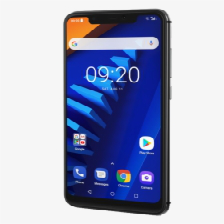

In [59]:
pic

In [60]:
numpy_image = keras.preprocessing.image.img_to_array(pic)
numpy_image.shape

(224, 224, 3)

In [61]:
image_batch = np.expand_dims(numpy_image, axis=0) # can also do with reshape
image_batch.shape

(1, 224, 224, 3)

In [62]:
processed_image = keras.applications.mobilenet_v2.preprocess_input(image_batch)

In [63]:
predictions = model.predict(processed_image)

predictions.round(3)

array([[0.   , 0.137, 0.663, 0.115, 0.   , 0.079, 0.006]], dtype=float32)

In [50]:
predictions.shape

(1, 1280)

In [53]:
MobilenetV2 = mobilenet_v2.MobileNetV2(
    weights='imagenet', 
    alpha=0.35,         # specific parameter of this model, small alpha reduces the number of overall weights
    pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
    include_top=True,  # we only want to have the base, not the final dense layers 
    input_shape=(224, 224, 3)
)

In [77]:
MobilenetV2.save("Base_model_Mobilenet.h5")
print("Saved model to disk")

Saved model to disk


In [64]:
predictions = MobilenetV2.predict(processed_image)

predictions.shape

(1, 1000)

In [65]:
label_mobilenet = keras.applications.mobilenet_v2.decode_predictions(
    predictions, top=5
)
label_mobilenet

[[('n03485407', 'hand-held_computer', 0.38593528),
  ('n02992529', 'cellular_telephone', 0.17448218),
  ('n03666591', 'lighter', 0.045594834),
  ('n03584254', 'iPod', 0.040567644),
  ('n04074963', 'remote_control', 0.02813075)]]

In [41]:
predictions_list = []

for i in range(len(classification_list)):
    predictions_temp = [classification_list[i], predictions[0,i].round(3)]
    #print('test')
    predictions_list.append(predictions_temp)
    
# using list comprehension 
listToStr = ' '.join([str(elem) for elem in predictions_list]) 
  
listToStr

"['apple', 0.011] ['avocado', 0.022] ['banana', 0.059] ['kaki', 0.011] ['lemon', 0.544] ['orange', 0.334] ['pumpkin', 0.019]"

## Save the model

In [20]:
model.save("model_mobilenet_allfruits.h5")
print("Saved model to disk")

Saved model to disk


In [67]:
from datetime import datetime

last_detected = datetime.now()


In [76]:
(datetime.now() - last_detected).total_seconds() == 5

False